## 1. Install required Packages

In [1]:
!pip install torchbnn


In [2]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
!pip install vit-pytorch


In [4]:
!pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.6 MB/s eta 0:00:00a 0:00:01


## 1.  Setup

In [5]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from captum.attr import IntegratedGradients, visualization
from vit_pytorch import ViT
import platform

# System Info  for exp setup 
print("System:", platform.platform())
print("Python version:", platform.python_version())
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


System: Linux-6.6.56+-x86_64-with-glibc2.35
Python version: 3.11.11
Torch version: 2.6.0+cu124
CUDA available: True


## 2. Load DFDC Data

In [6]:
# Dataset Class
class ASDataset(Dataset):
    def __init__(self, client_file: str, imposter_file: str, transforms=None):
        with open(client_file, "r") as f:
            client_files = f.read().splitlines()
        with open(imposter_file, "r") as f:
            imposter_files = f.read().splitlines()

        self.labels = torch.cat((torch.ones(len(client_files)), torch.zeros(len(imposter_files))))
        self.imgs = client_files + imposter_files
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img = Image.open(img_name).convert("RGB")
        label = self.labels[idx]
        if self.transforms:
            img = self.transforms(img)
        return img, label

# Image Preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Data
train_dataset = ASDataset(
    client_file="/kaggle/input/dfdcdfdc/TRAIN_CLIENT.txt",
    imposter_file="/kaggle/input/dfdcdfdc/TRAIN_IMPOSTER.txt",
    transforms=preprocess
)

val_dataset = ASDataset(
    client_file="/kaggle/input/dfdcdfdc/TEST_CLIENT.txt",
    imposter_file="/kaggle/input/dfdcdfdc/TEST_IMPOSTER.txt",
    transforms=preprocess
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 3. Training  

In [7]:
# Training Function

def train_model(model, optimizer, criterion, loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.unsqueeze(-1).to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {running_loss / len(loader):.4f}")

In [8]:
# Evaluation Function

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())
    auc = roc_auc_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, (np.array(all_preds) > 0.5).astype(int))
    return {"AUC": auc, "Accuracy": accuracy}

## 4.ViT Experiments with differnet Configs and Model Saving

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
vit_params = [
    {"dim": 512, "depth": 6, "heads": 8},
    {"dim": 768, "depth": 8, "heads": 12},
    {"dim": 1024, "depth": 12, "heads": 16}
]

vit_results = []

for i, params in enumerate(vit_params):
    print(f"\n--- Training ViT Config {i+1}: {params} ---")

    vit_model = ViT(
        image_size=224,
        patch_size=32,
        num_classes=1,
        dim=params["dim"],
        depth=params["depth"],
        heads=params["heads"],
        mlp_dim=2048,
        dropout=0.1,
        emb_dropout=0.1,
    ).to(device)

    vit_optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=5e-4)
    
    train_model(vit_model, vit_optimizer, criterion, train_loader, num_epochs=5)

    # Save the trained model
    model_filename = f"/kaggle/working/vit_config_{i+1}.pt"
    torch.save(vit_model.state_dict(), model_filename)
    print(f" Saved model to: {model_filename}")

    metrics = evaluate_model(vit_model, val_loader)
    
    vit_results.append({
        "config": params,
        "metrics": metrics,
        "model_path": model_filename
    })

# Optional: Display summary of results
for result in vit_results:
    print(f"Config: {result['config']} → AUC: {result['metrics']['AUC']:.4f}, Accuracy: {result['metrics']['Accuracy']:.4f}")


--- Training ViT Config 1: {'dim': 512, 'depth': 6, 'heads': 8} ---


Epoch 1: 100%|██████████| 2500/2500 [19:18<00:00,  2.16it/s]


Epoch 1: Loss = 0.3894


Epoch 2: 100%|██████████| 2500/2500 [13:55<00:00,  2.99it/s]


Epoch 2: Loss = 0.2580


Epoch 3: 100%|██████████| 2500/2500 [14:06<00:00,  2.95it/s]


Epoch 3: Loss = 0.2163


Epoch 4: 100%|██████████| 2500/2500 [13:55<00:00,  2.99it/s]


Epoch 4: Loss = 0.1923


Epoch 5: 100%|██████████| 2500/2500 [14:06<00:00,  2.95it/s]


Epoch 5: Loss = 0.1771
 Saved model to: /kaggle/working/vit_config_1.pt

--- Training ViT Config 2: {'dim': 768, 'depth': 8, 'heads': 12} ---


Epoch 1: 100%|██████████| 2500/2500 [17:23<00:00,  2.40it/s]


Epoch 1: Loss = 0.3792


Epoch 2: 100%|██████████| 2500/2500 [17:14<00:00,  2.42it/s]


Epoch 2: Loss = 0.2443


Epoch 3: 100%|██████████| 2500/2500 [17:13<00:00,  2.42it/s]


Epoch 3: Loss = 0.2043


Epoch 4: 100%|██████████| 2500/2500 [17:12<00:00,  2.42it/s]


Epoch 4: Loss = 0.1836


Epoch 5: 100%|██████████| 2500/2500 [17:17<00:00,  2.41it/s]


Epoch 5: Loss = 0.1682
 Saved model to: /kaggle/working/vit_config_2.pt

--- Training ViT Config 3: {'dim': 1024, 'depth': 12, 'heads': 16} ---


Epoch 1: 100%|██████████| 2500/2500 [25:39<00:00,  1.62it/s]


Epoch 1: Loss = 0.3845


Epoch 2: 100%|██████████| 2500/2500 [25:39<00:00,  1.62it/s]


Epoch 2: Loss = 0.2482


Epoch 3: 100%|██████████| 2500/2500 [25:28<00:00,  1.64it/s]


Epoch 3: Loss = 0.2068


Epoch 4: 100%|██████████| 2500/2500 [25:21<00:00,  1.64it/s]


Epoch 4: Loss = 0.1868


Epoch 5: 100%|██████████| 2500/2500 [25:21<00:00,  1.64it/s]


Epoch 5: Loss = 0.1704
 Saved model to: /kaggle/working/vit_config_3.pt
Config: {'dim': 512, 'depth': 6, 'heads': 8} → AUC: 0.9801, Accuracy: 0.9063
Config: {'dim': 768, 'depth': 8, 'heads': 12} → AUC: 0.9816, Accuracy: 0.8942
Config: {'dim': 1024, 'depth': 12, 'heads': 16} → AUC: 0.9756, Accuracy: 0.8816


## 5. XAI, Inferences 

In [10]:
from vit_pytorch import ViT

config = {"dim": 768, "depth": 8, "heads": 12}
model_path = "/kaggle/working/vit_config_2.pt"

vit_model = ViT(
    image_size=224,
    patch_size=32,
    num_classes=1,
    dim=config["dim"],
    depth=config["depth"],
    heads=config["heads"],
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
).to(device)

vit_model.load_state_dict(torch.load(model_path))
vit_model.eval()
print("Model loaded for XAI or inference")

Model loaded for XAI or inference


## 6.  Metrics Summary

In [11]:
print("\n=== ViT Configuration Results ===")
for i, result in enumerate(vit_results):
    config = result['config']
    metrics = result['metrics']
    print(f"Config {i+1}: dim={config['dim']}, depth={config['depth']}, heads={config['heads']} → "
          f"AUC: {metrics['AUC']:.4f}, Accuracy: {metrics['Accuracy']:.4f}")


=== ViT Configuration Results ===
Config 1: dim=512, depth=6, heads=8 → AUC: 0.9801, Accuracy: 0.9063
Config 2: dim=768, depth=8, heads=12 → AUC: 0.9816, Accuracy: 0.8942
Config 3: dim=1024, depth=12, heads=16 → AUC: 0.9756, Accuracy: 0.8816


## 7. Metric comparision 

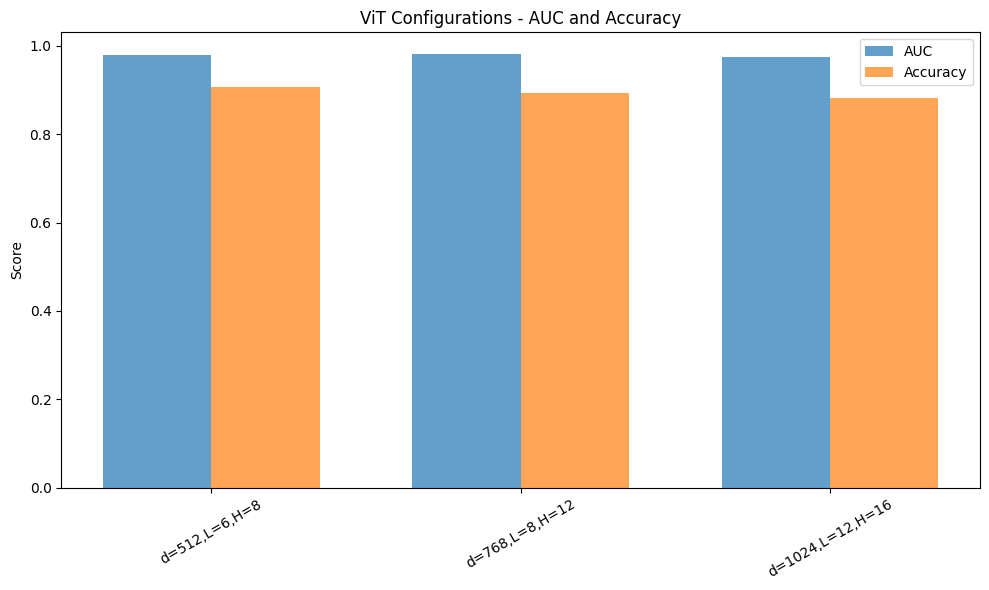

In [12]:
# Plot Metrics Comparison 
labels = [f"d={r['config']['dim']},L={r['config']['depth']},H={r['config']['heads']}" for r in vit_results]
auc_scores = [r['metrics']['AUC'] for r in vit_results]
acc_scores = [r['metrics']['Accuracy'] for r in vit_results]

x = range(len(labels))
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x, auc_scores, width=width, label='AUC', alpha=0.7)
plt.bar([p + width for p in x], acc_scores, width=width, label='Accuracy', alpha=0.7)
plt.xticks([p + width/2 for p in x], labels, rotation=30)
plt.ylabel("Score")
plt.title("ViT Configurations - AUC and Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## 8. XAI with Integrated Gradients (IG)

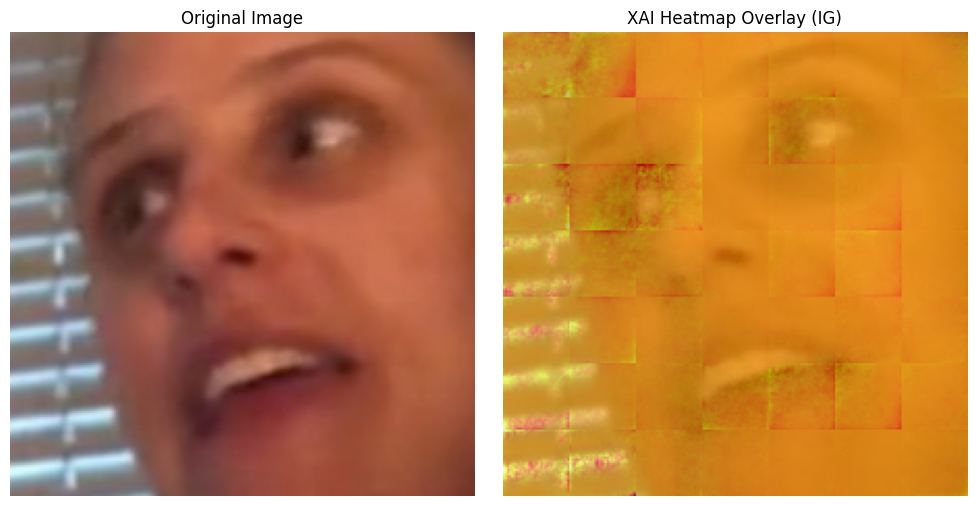

In [13]:
from captum.attr import IntegratedGradients

# Load a model (e.g., best one - config 2)
model_path = vit_results[1]['model_path']  # Config 2
config = vit_results[1]['config']

model = ViT(
    image_size=224,
    patch_size=32,
    num_classes=1,
    dim=config["dim"],
    depth=config["depth"],
    heads=config["heads"],
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
).to(device)

model.load_state_dict(torch.load(model_path))
model.eval()

# Use a sample image
sample_input, _ = next(iter(val_loader))
sample_image = sample_input[0].unsqueeze(0).to(device)

# Generate attribution map
ig = IntegratedGradients(model)
attributions = ig.attribute(sample_image, target=0)

# Unnormalize and visualize
original = sample_image.squeeze().cpu().detach().numpy()
original = np.transpose(original, (1, 2, 0))
original = (original * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

attr_map = attributions.squeeze().cpu().detach().numpy()
attr_map = np.transpose(attr_map, (1, 2, 0))

# Plot both images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original.clip(0, 1))
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(original.clip(0, 1))
axs[1].imshow(np.mean(attr_map, axis=-1), cmap='hot', alpha=0.6)
axs[1].set_title("XAI Heatmap Overlay (IG)")
axs[1].axis("off")
plt.tight_layout()
plt.show()

## 9. XAI with LIME (Random Image)

  0%|          | 0/1000 [00:00<?, ?it/s]

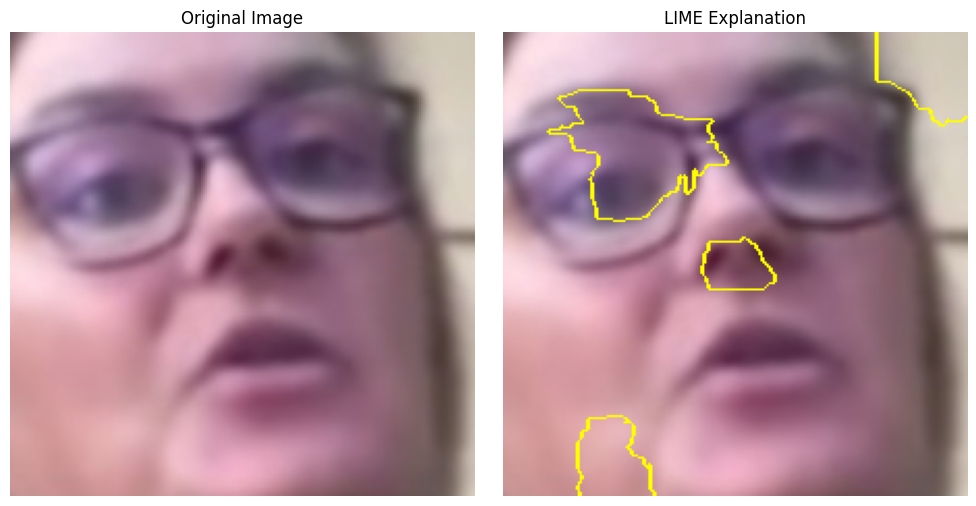

In [14]:
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Pick a random image from the dataset
random_idx = random.randint(0, len(val_dataset) - 1)
img_tensor, _ = val_dataset[random_idx]

# Convert tensor to numpy image
image_np = np.transpose(img_tensor.numpy(), (1, 2, 0))
image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
image_np = np.uint8(np.clip(image_np * 255, 0, 255))

# Define LIME prediction wrapper
def predict_fn(images):
    model.eval()
    images_tensor = torch.stack([preprocess(Image.fromarray(img)) for img in images]).to(device)
    with torch.no_grad():
        outputs = model(images_tensor)
        probs = torch.sigmoid(outputs).cpu().numpy()
    return np.concatenate([1 - probs, probs], axis=1)

# Run LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_np, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Show original and LIME output
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=False)
axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title("LIME Explanation")
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [15]:
# from captum.attr import IntegratedGradients, visualization
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# # Ensure the model is in evaluation mode
# model = vit_results[0]['model']
# model.eval()

# # Get a sample image from validation loader
# sample_input, _ = next(iter(val_loader))   # batch of images
# sample_image = sample_input[0].unsqueeze(0).to(device)  # pick the first image and move to device

# # Set up Integrated Gradients
# ig = IntegratedGradients(model)

# # Generate attributions
# attributions = ig.attribute(sample_image, target=0)

# # Convert tensors to numpy arrays
# original = sample_image.squeeze().cpu().detach().numpy()
# original = np.transpose(original, (1, 2, 0))  # CHW to HWC

# attr_map = attributions.squeeze().cpu().detach().numpy()
# attr_map = np.transpose(attr_map, (1, 2, 0))  # CHW to HWC

# # Plot side-by-side
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow((original * 0.229 + 0.485).clip(0, 1))  # un-normalize
# axs[0].set_title("Original Input Image")
# axs[0].axis("off")

# axs[1].imshow((original * 0.229 + 0.485).clip(0, 1))
# axs[1].imshow(np.mean(attr_map, axis=-1), cmap='hot', alpha=0.6)
# axs[1].set_title("XAI Heatmap Overlay (IG)")
# axs[1].axis("off")

# plt.tight_layout()
# plt.show()

## LIME for ViT

In [16]:
# import numpy as np
# import random
# from lime import lime_image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt

# # Select a random index from the full validation dataset
# random_idx = random.randint(0, len(val_dataset) - 1)
# img_tensor, _ = val_dataset[random_idx]

# # Convert tensor to numpy image for LIME
# image_np = np.transpose(img_tensor.numpy(), (1, 2, 0))
# image_np = (image_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
# image_np = np.uint8(np.clip(image_np * 255, 0, 255))

# # Define prediction wrapper for LIME
# def predict_fn(images):
#     model.eval()
#     images_tensor = torch.stack([preprocess(Image.fromarray(img)) for img in images]).to(device)
#     with torch.no_grad():
#         outputs = model(images_tensor)
#         probs = torch.sigmoid(outputs).cpu().numpy()
#     return np.concatenate([1 - probs, probs], axis=1)

# # Run LIME
# explainer = lime_image.LimeImageExplainer()
# explanation = explainer.explain_instance(image_np, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# # Visualize both original and LIME heatmap
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Original image
# axes[0].imshow(image_np)
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# # LIME explanation
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=False)
# axes[1].imshow(mark_boundaries(temp, mask))
# axes[1].set_title("LIME Explanation")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()


## 11. Define Models CNN , BNN and ViT

### A. CNN Model

In [17]:
## CNN Baseline Definition

class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        return self.fc2(x)

### B. CNN Metics

In [ ]:
cnn_model = CNNBaseline().to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=5e-4)

train_model(cnn_model, cnn_optimizer, criterion, train_loader, num_epochs=5)
cnn_metrics = evaluate_model(cnn_model, val_loader)

print(f"\nCNN Baseline → AUC: {cnn_metrics['AUC']:.4f}, Accuracy: {cnn_metrics['Accuracy']:.4f}")


Epoch 1: 100%|██████████| 2500/2500 [15:32<00:00,  2.68it/s]  


Epoch 1: Loss = 0.3210


Epoch 2:  82%|████████▏ | 2040/2500 [12:09<02:46,  2.76it/s]

### B. BNN Model

In [ ]:
print("test")

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchbnn as bnn  # Ensure torchbnn is installed

# class BNNModel(nn.Module):
#     def __init__(self, prior_mu=0.0, prior_sigma=1.0):
#         super(BNNModel, self).__init__()
        
#         # Bayesian convolutional layers with priors
#         self.conv1 = bnn.BayesConv2d(
#             in_channels=3, 
#             out_channels=32, 
#             kernel_size=3, 
#             stride=1, 
#             padding=1, 
#             prior_mu=prior_mu, 
#             prior_sigma=prior_sigma
#         )
#         self.conv2 = bnn.BayesConv2d(
#             in_channels=32, 
#             out_channels=64, 
#             kernel_size=3, 
#             stride=1, 
#             padding=1, 
#             prior_mu=prior_mu, 
#             prior_sigma=prior_sigma
#         )
        
#         # Pooling layer
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # Fully connected Bayesian layers with priors
#         self.fc1 = bnn.BayesLinear(
#             in_features=64 * 56 * 56, 
#             out_features=512, 
#             prior_mu=prior_mu, 
#             prior_sigma=prior_sigma
#         )
#         self.fc2 = bnn.BayesLinear(
#             in_features=512, 
#             out_features=1, 
#             prior_mu=prior_mu, 
#             prior_sigma=prior_sigma
#         )

#     def forward(self, x):
#         # Forward pass through Bayesian layers
#         x = self.pool(nn.ReLU()(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
#         x = self.pool(nn.ReLU()(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        
#         # Flatten the output for fully connected layers
#         x = x.view(x.size(0), -1)
        
#         # Fully connected layers
#         x = nn.ReLU()(self.fc1(x))
#         x = self.fc2(x)
        
#         return x

### 11. Metric Comparision

In [ ]:
import matplotlib.pyplot as plt

# Extract ViT Config 2 metrics
vit2_metrics = vit_results[1]["metrics"]

# Prepare data
models = ['CNN', 'ViT Config 2\n(dim=768, depth=8, heads=12)']
auc_scores = [cnn_metrics['AUC'], vit2_metrics['AUC']]
acc_scores = [cnn_metrics['Accuracy'], vit2_metrics['Accuracy']]

# Plot
x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, auc_scores, width=width, label='AUC', alpha=0.8)
plt.bar([p + width for p in x], acc_scores, width=width, label='Accuracy', alpha=0.6)

plt.xticks([p + width / 2 for p in x], models)
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("Model Performance Comparison: CNN vs ViT Config 2")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compare AUC and Accuracy
metrics = {
    "Model": ["CNN", "ViT"],
    "AUC": [cnn_metrics["AUC"], vit_metrics["AUC"]],
    "Accuracy": [cnn_metrics["Accuracy"], vit_metrics["Accuracy"]],
}

# Plot
plt.bar(metrics["Model"], metrics["AUC"], alpha=0.6, label="AUC")
plt.bar(metrics["Model"], metrics["Accuracy"], alpha=0.6, label="Accuracy")
plt.xlabel("Model")
plt.ylabel("Metric")
plt.legend()
plt.title("Model Comparison")
plt.show()